In [1]:
from astropy.io import fits
from scipy import signal
from matplotlib import pyplot as plt
import numpy as np
import os
from importlib import reload
import pandas as pd

# package imports
import sparkles.spark as spkl
import sparkles.file_reader as fr
import sparkles.log_readers as lr

## Demo selfRM method plots

In [2]:
RM_dir = '/home/eden/data/2023A/selfRMs/'
selfRM_compare = pd.read_csv('/home/eden/code/sparkles/telem/selfRM_lab_to_sky.csv')
selfRM_telem = pd.read_csv('/home/eden/code/sparkles/telem/selfMR_total_telem.csv')
selfRM_compare.sort_values(by=['selfRM'], inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/eden/code/sparkles/telem/selfMR_total_telem.csv'

In [42]:
# picking only the sky selfRMs
df_telem = selfRM_telem.loc[selfRM_telem['type'] == 'SKY']
df_telem_OG = pd.merge(df_telem, selfRM_compare,  on= ['selfRM'])

In [43]:
# I want to know number of modes so that I can seperate out gain 
mode_counts = np.array([1, 1, 1, 14, 29, 60, 87, 105, 113, 125, 145, 166, 166, 194, 357])
mode_cumulative = np.cumsum(mode_counts)
modes_list = []
for idx, row in df_telem_OG.iterrows():
    # ok so take the column with the mode gains
    gains = np.array([float(x) for x in row['gains'].replace("[", '').replace(']', '').split(',')])
    # make a TRUE FALSE column of 1's and 0's if above or below 
    compare = np.where(gains > 0, 1, 0)
    # multiply with the mode_counts, then sum
    n_modes = np.sum(compare*mode_counts)
    modes_list.append(n_modes) 
df_telem_OG["n_modes"] = modes_list

In [45]:
# want to make a 3 axis graph that displays 
df_display = df_telem_OG.loc[df_telem_OG['n_modes'] == 411]
df_display.sort_values(by=['dimm_fwhm'], inplace=True)

/tmp/ipykernel_31473/4017132489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_display.sort_values(by=['dimm_fwhm'], inplace=True)


In [46]:
df_display['selfRM:1'].unique()

array(['selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits',
       'selfRM_20230315_LAB_spark_1800_020amps_20seps_1Hz.fits',
       'selfRM_20230307_08_lab_sparkles_sep20_amp002.fits'], dtype=object)

In [47]:
sky_sRMs = df_display.selfRM.unique()
lab_sRM = 'selfRM_20230311_12_LAB_spark_1800_020amps_20seps.fits'

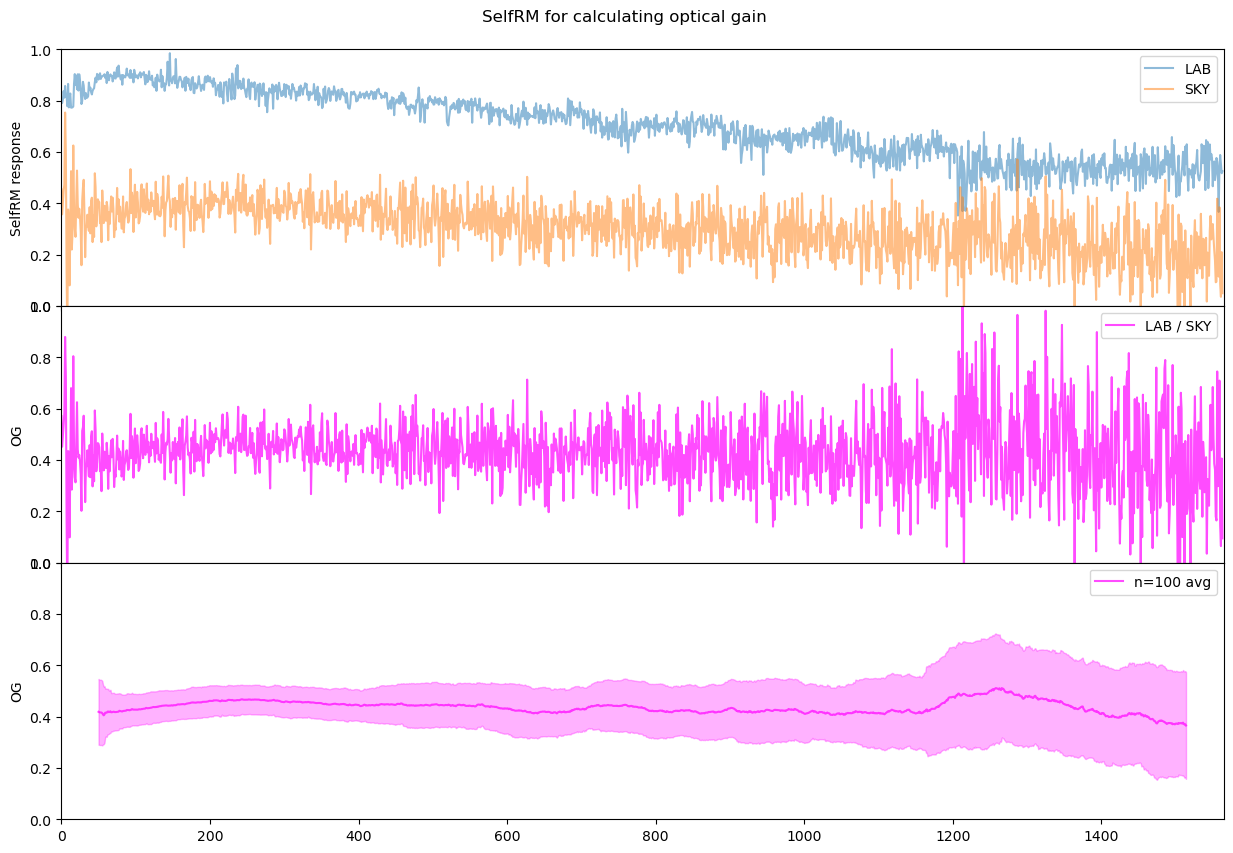

In [48]:
# PLOT: selfRM demonstration
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), facecolor='white', sharex=True)
plt.suptitle(f"SelfRM for calculating optical gain", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7,4))

# Data I am planning on using
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])
sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[0])[0].data[5])
og_ex = sky_data_x / lab_data

data_avg, data_s = spkl.return_rolling(og_ex, n=100)
X = np.arange(data_avg.shape[0])
X_shift = np.arange(50, data_avg.shape[0] + 50)

# ROW 1: raw selfRM and optical gain 
axs[0].plot(lab_data, label = 'LAB', alpha=0.5)
axs[0].plot(sky_data_x, label = 'SKY', alpha=0.5)
axs[0].legend()
axs[0].set_ylabel('SelfRM response')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1565)

# ROW 2: divide for optical gain
axs[1].plot(og_ex, color = 'magenta', alpha=0.7, label='LAB / SKY')
axs[1].set_ylabel('OG')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1565)
axs[1].legend()

#ROW 3: smoth to show general shape
axs[2].fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.3, color='magenta')
axs[2].plot(X_shift, data_avg, color='magenta', alpha=0.7, label='n=100 avg')
axs[2].set_ylabel('OG')
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1565)
axs[2].legend()

plt.show()

In [49]:
sky_DIMMS = df_display['dimm_fwhm'].unique()

In [50]:
sky_DIMMS

array([0.71, 0.88, 1.09, 1.25, 1.42])

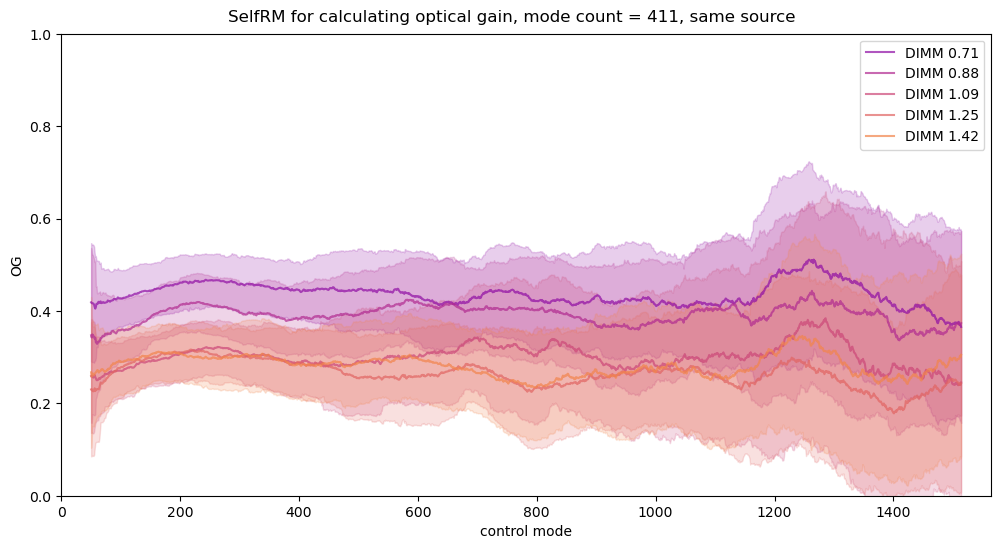

In [53]:
# PLOT: OG across multiple selfRM files
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), facecolor='white', sharex=True)
plt.suptitle(f"SelfRM for calculating optical gain, mode count = 411, same source", y=0.92 )
fig.subplots_adjust(hspace=0)
colors = plt.cm.plasma(np.linspace(0.3,.7, len(sky_sRMs)))

#only need to pull lab data once
lab_data = np.diag(fits.open(RM_dir + 'LAB/' + lab_sRM)[0].data[5])

# go through all selfRMs and check
for i, s in enumerate(sky_sRMs):
    #calc OG for this file
    sky_data_x  = np.diag(fits.open(RM_dir + 'SKY/' + sky_sRMs[i])[0].data[5])
    og_ex = sky_data_x / lab_data

    data_avg, data_s = spkl.return_rolling(og_ex, n=100)
    X_shift = np.arange(50, data_avg.shape[0] + 50)

    axs.fill_between(X_shift, data_avg - data_s, data_avg + data_s, alpha = 0.2, color=colors[i])
    axs.plot(X_shift, data_avg, alpha=0.7, label=f'DIMM {sky_DIMMS[i]}', color=colors[i])

axs.set_ylabel('OG')
axs.set_xlabel('control mode')
axs.set_ylim(0,1)
axs.set_xlim(0,1565)
axs.legend()



# SelfRMs vs. Seeing vs. Modes

In this notebooks I will attempt to get modal information about the different observations. 

Things to think about: 
- mapping from gain array to the modes found
- making sure each selfRM has its 

In [2]:
reload(fr)

<module 'sparkles.file_reader' from '/home/eden/code/sparkles/sparkles/file_reader.py'>

## part 0. Making selfRM table

In [2]:
log_dir_23A = "/home/eden/data/2023A/log/"
f_spark_telem = log_dir_23A + 'spkl_teldump_23A_clean.csv'
df_spkl_telem = pd.read_csv(f_spark_telem)

In [3]:
df_spkl_telem

,UT,MOD,TRIG,HZ,SEPS,ANGS,AMPS
0,2022-12-02T18:38:05,False,False,NaN,NaN,NaN,NaN
1,2022-12-02T18:38:15,False,False,NaN,NaN,NaN,NaN
2,2022-12-02T18:38:25,False,False,NaN,NaN,NaN,NaN
3,2022-12-02T18:38:35,False,False,NaN,NaN,NaN,NaN
4,2022-12-02T19:24:00,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
270395,2023-03-17T10:44:02,False,False,NaN,NaN,NaN,NaN
270396,2023-03-17T10:44:12,False,False,NaN,NaN,NaN,NaN
270397,2023-03-17T10:44:22,False,False,NaN,NaN,NaN,NaN
270398,2023-03-17T10:44:32,False,False,NaN,NaN,NaN,NaN


In [13]:
RM_dir23A_lab = "/home/eden/data/selfRMs_all/LAB/"
RM_dir23A_sky = "/home/eden/data/selfRMs_all/SKY/"
RM_dir23A_tst = "/home/eden/data/selfRMs_all/TST/"
selfRM_lab_list = os.listdir(RM_dir23A_lab)
selfRM_sky_list = os.listdir(RM_dir23A_sky)
selfRM_tst_list = os.listdir(RM_dir23A_tst)

In [9]:
selfRM_lab_list

['selfRM_20230307_08_lab_sparkles_sep20_amp002.fits',
 'selfRM_20230311_12_LAB_loopOff_1800_20stlng.fits',
 'selfRM_20230311_12_LAB_noSpark_0600_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_0900_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_1200_fullgains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_000gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_020gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_040gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_060gains.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_20stlng.fits',
 'selfRM_20230311_12_LAB_noSpark_1800_fullgains.fits',
 'selfRM_20230311_12_LAB_spark_0600_010amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0600_020amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0600_050amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_010amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_020amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_0900_050amps_20seps.fits',
 'selfRM_20230311_12_LAB_spark_1200_010amps_20seps.fits'

In [14]:
selfRM_param_list = []
for tmp in selfRM_sky_list:
    tmp_path = RM_dir23A_sky + tmp
    param_tmp = [tmp, "SKY"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)
for tmp in selfRM_lab_list:
    tmp_path = RM_dir23A_lab + tmp
    param_tmp = [tmp, "LAB"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)
for tmp in selfRM_tst_list:
    tmp_path = RM_dir23A_tst + tmp
    param_tmp = [tmp, "TST"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, f_spark_telem))
    selfRM_param_list.append(param_tmp)

2023-03-05T05:24:10
2023-03-05T05:18:53
2023-03-07T03:53:53
2023-03-08T02:17:29
2023-03-10T07:51:12
2023-03-10T10:02:12
2023-03-10T22:49:41
2023-03-11T03:32:47
2023-03-11T03:35:49
2023-03-11T03:29:49
2023-03-12T03:01:06
2023-03-13T04:15:30
2023-03-13T02:20:10
2023-03-13T02:25:21
2023-03-13T10:20:47
2023-03-14T05:51:29
2023-03-16T00:57:06
2023-03-16T02:50:26
2023-03-16T03:08:40
2023-03-16T10:24:33
2023-03-16T07:02:31
2023-03-17T03:53:33
2023-03-17T04:14:23
2023-03-17T04:28:52
2023-03-17T04:34:56
2023-03-17T04:42:36
2023-03-17T04:50:10
2023-03-17T04:59:39
2023-03-17T07:23:42
2023-03-17T03:09:30
2023-03-17T03:09:30
2023-03-17T09:57:39
2022-12-11T02:21:27
2022-12-12T01:48:57
2022-12-11T02:24:20
2022-12-13T03:32:15
2023-03-08T00:06:36
2023-03-11T23:28:09
2023-03-11T22:00:40
2023-03-11T22:38:40
2023-03-11T21:27:24
2023-03-11T20:44:06
2023-03-11T20:32:40
2023-03-11T22:20:58
2023-03-11T22:10:35
2023-03-11T21:53:36
2023-03-11T22:54:43
2023-03-11T22:46:49
2023-03-11T22:34:34
2023-03-11T21:40:51


In [15]:
sRM_columns = ['selfRM', 'type', 'UT', 'MOD', 'TRIG', 'HZ', 'SEPS','ANGS','AMPS']
df_selfRM_spark = pd.DataFrame(selfRM_param_list, columns = sRM_columns)

In [16]:
df_selfRM_spark.to_csv('/srv/nas/users/eden/selfRM_telem_22B_23A_more.csv')

### EDITING the comparison csv made

In [ ]:
log_dir_23A = "/home/eden/data/2023A/log/"
f_spark_telem = log_dir_23A + 'spkl_teldump_23A_clean.csv'
df_spkl_telem = pd.read_csv(f_spark_telem)

### Part 1. aggregating Self RMs and seeing into a table

In [4]:
# Log used for the merged data lookup
log_dir =  "/home/eden/code/sparkles/dev/"
merged_f = log_dir + "merge_spk_tsci.csv"
df_seeing_param  = pd.read_csv(merged_f)

In [ ]:
# Make a selfRM table with 

In [ ]:
# TODO: expand the merged df to include teh 3/17 dates
# this requires us to re-pull telemetry files

In [17]:
# create a df using the sparkle parameter lists
# this list gives the seeing values as well
selfRM_param_list = []
for tmp in selfRM_sky_list:
    tmp_path = RM_dir23A_sky + tmp
    param_tmp = [tmp, "SKY"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, merged_f))
    selfRM_param_list.append(param_tmp)
for tmp in selfRM_lab_list:
    tmp_path = RM_dir23A_lab + tmp
    param_tmp = [tmp, "LAB"]
    param_tmp.extend(fr.get_spark_params_selfRM(tmp_path, merged_f))
    selfRM_param_list.append(param_tmp)


2023-03-05T05:24:10
2023-03-05T05:18:53
2023-03-07T03:53:53
2023-03-08T02:17:29
2023-03-10T10:02:12
2023-03-10T07:51:12
2023-03-10T22:49:41
2023-03-11T03:32:47
2023-03-11T03:35:49
2023-03-11T03:29:49
2023-03-12T03:01:06
2023-03-13T04:15:30
2023-03-13T02:25:21
2023-03-13T02:20:10
2023-03-13T10:20:47
2023-03-14T05:51:29
2023-03-16T00:57:06
2023-03-16T02:50:26
2023-03-16T03:08:40
2023-03-16T10:24:33
2023-03-16T07:02:31
2023-03-17T03:53:33
error:  positional indexers are out-of-bounds
2023-03-17T04:14:23
error:  positional indexers are out-of-bounds
2023-03-17T04:28:52
error:  positional indexers are out-of-bounds
2023-03-17T04:34:56
error:  positional indexers are out-of-bounds
2023-03-17T04:42:36
error:  positional indexers are out-of-bounds
2023-03-17T04:50:10
error:  positional indexers are out-of-bounds
2023-03-17T04:59:39
error:  positional indexers are out-of-bounds
2023-03-17T07:23:42
error:  positional indexers are out-of-bounds
2023-03-17T03:09:30
error:  positional indexers are 

In [32]:
# TODO: This one is wrong!! Not sure why. 
selfRM_params_df = pd.DataFrame(selfRM_param_list, columns=['selfRM','type',"UT","DSEEING","DSEEING_COR","BSEEING","BSEEING_COR","DIMM_diff","MOD","TRIG","HZ","SEPS","ANGS","AMPS"])
selfRM_params_df

,selfRM,type,UT,DSEEING,DSEEING_COR,BSEEING,BSEEING_COR,DIMM_diff,MOD,TRIG,HZ,SEPS,ANGS,AMPS
0,selfRM_20230304_05_piPup_sparkles_nottriggered...,SKY,2023-03-06 00:13:54,-1.00,-1.000000,-1.00,-1.000000,-2.18,False,False,NaN,NaN,NaN,NaN
1,selfRM_20230304_05_piPup_sparkles_triggered.fits,SKY,2023-03-06 00:13:54,-1.00,-1.000000,-1.00,-1.000000,-2.18,False,False,NaN,NaN,NaN,NaN
2,selfRM_20230305_06_betaPic_sparkles_triggered....,SKY,2023-03-08 00:03:03,0.70,0.674357,-1.00,-1.000000,1.70,True,True,NaN,20.0,0.0,0.02
3,selfRM_20230307_08_betaPic_sparkles_trigger_se...,SKY,2023-03-09 03:32:08,0.72,0.672866,0.83,0.712202,-0.01,False,False,NaN,NaN,NaN,NaN
4,selfRM_20230309_10_cutoff.fits,SKY,2023-03-11 02:45:04,0.81,0.761232,-1.00,-1.000000,-0.06,True,True,NaN,15.0,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,selfRM_20230316_LAB_spark_1800_020amps_22seps....,LAB,2023-03-17 00:06:03,0.86,0.836195,-1.00,-1.000000,0.12,False,False,NaN,NaN,NaN,NaN
61,selfRM_20230316_LAB_spark_1800_020amps_22seps_...,LAB,2023-03-17 00:06:03,0.86,0.836195,-1.00,-1.000000,0.12,False,False,NaN,NaN,NaN,NaN
62,selfRM_20230522_LAB_spark_1799_020amps_20seps....,LAB,2022-12-05 09:13:55,-1.00,-1.000000,-1.00,-1.000000,-1.90,True,True,NaN,10.0,0.0,0.04
63,selfRM_20230522_LAB_spark_1800_1Hz_020amps_20s...,LAB,2022-12-05 09:13:55,-1.00,-1.000000,-1.00,-1.000000,-1.90,True,True,NaN,10.0,0.0,0.04


In [19]:
# need a function to translate the self rm to a time stamp



,selfRM,type,UT,DSEEING,DSEEING_COR,BSEEING,BSEEING_COR,DIMM_diff,MOD,TRIG,HZ,SEPS,ANGS,AMPS
0,selfRM_20230304_05_piPup_sparkles_nottriggered...,SKY,2023-03-06 00:13:54,-1.00,-1.000000,-1.00,-1.000000,-2.18,False,False,NaN,NaN,NaN,NaN
1,selfRM_20230304_05_piPup_sparkles_triggered.fits,SKY,2023-03-06 00:13:54,-1.00,-1.000000,-1.00,-1.000000,-2.18,False,False,NaN,NaN,NaN,NaN
2,selfRM_20230305_06_betaPic_sparkles_triggered....,SKY,2023-03-08 00:03:03,0.70,0.674357,-1.00,-1.000000,1.70,True,True,NaN,20.0,0.0,0.02
3,selfRM_20230307_08_betaPic_sparkles_trigger_se...,SKY,2023-03-09 03:32:08,0.72,0.672866,0.83,0.712202,-0.01,False,False,NaN,NaN,NaN,NaN
4,selfRM_20230309_10_cutoff.fits,SKY,2023-03-11 02:45:04,0.81,0.761232,-1.00,-1.000000,-0.06,True,True,NaN,15.0,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,selfRM_20230316_LAB_spark_1800_020amps_22seps....,LAB,2023-03-17 00:06:03,0.86,0.836195,-1.00,-1.000000,0.12,False,False,NaN,NaN,NaN,NaN
61,selfRM_20230316_LAB_spark_1800_020amps_22seps_...,LAB,2023-03-17 00:06:03,0.86,0.836195,-1.00,-1.000000,0.12,False,False,NaN,NaN,NaN,NaN
62,selfRM_20230522_LAB_spark_1799_020amps_20seps....,LAB,2022-12-05 09:13:55,-1.00,-1.000000,-1.00,-1.000000,-1.90,True,True,NaN,10.0,0.0,0.04
63,selfRM_20230522_LAB_spark_1800_1Hz_020amps_20s...,LAB,2022-12-05 09:13:55,-1.00,-1.000000,-1.00,-1.000000,-1.90,True,True,NaN,10.0,0.0,0.04


### Part 2. Match LAB to SKY for gain calc

In [21]:
# create teo lists, one with 
self_params_sky = selfRM_params_df.loc[selfRM_params_df['type'] == 'SKY']
self_params_lab = selfRM_params_df.loc[selfRM_params_df['type'] == 'LAB']

In [31]:
# iter over DF:
for idx,row in self_params_sky.iterrows():
    # find the clossest lab
    print(row['MOD'], row['AMPS'], row['selfRM'])

False nan selfRM_20230304_05_piPup_sparkles_nottriggered.fits
False nan selfRM_20230304_05_piPup_sparkles_triggered.fits
True 0.02 selfRM_20230305_06_betaPic_sparkles_triggered.fits
False nan selfRM_20230307_08_betaPic_sparkles_trigger_sep20_amp02.fits
True 0.05 selfRM_20230309_10_cutoff.fits
True 0.05 selfRM_20230309_10_HR4796a_sparkles.fits
True 0.05 selfRM_20230309_10_noSpark_1200Hz.fits
True 0.02 selfRM_20230310_11_no_sparkles_HD72946b.fits
True 0.02 selfRM_20230310_11_no_sparkles_HD72946b_lower_gain_02.fits
True 0.02 selfRM_20230310_11_trig_sparkles_HD72946b_15ld_05.fits
True 0.02 selfRM_20230311_12_TWA7_sparkles_sep15_amp02.fits
False nan selfRM_20230312_13_HD106906_sep15_amp_02.fits
False nan selfRM_20230312_13_HR2562_sep15_amp_02_05gains.fits
False nan selfRM_20230312_13_HR2562_sep15_amp_02.fits
False nan selfRM_20230312_13_PSF-HD144271_sep13_amp02.fits
True 0.015 selfRM_20230313_14_HD100546_sep15_amp016.fits
False nan selfRM_20230316_0055_BetaPic_spark_020amps_22seps.fits
Fals

In [2]:
for tmp in selfRM_sky_list:
    print(tmp)
    qry = lr.query_teldump_csv_selfRM(RM_dir23A_sky+tmp, merged_f)
    #print(qry)

NameError: name 'selfRM_sky_list' is not defined